# Top-label calibration for outputs of ML models

The goal of this notebook is to present :class:`mapie.calibration.MapieCalibrator` by comparing it to the method presented in the paper for Top-label calibration [1].

[1] Gupta, Chirag, and Aaditya K. Ramdas. "Top-label calibration and multiclass-to-binary reductions." arXiv preprint arXiv:2107.08353 (2021).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/scikit-learn-contrib/MAPIE/blob/master/notebooks/classification/top_label_calibration.ipynb)


# Tutorial preparation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier


### Import calibration GitHub
Import the calibration GitHub of for the paper on Top-label calibration [1].


In [2]:
!git clone https://github.com/AIgen/df-posthoc-calibration

Cloning into 'df-posthoc-calibration'...
remote: Enumerating objects: 309, done.
remote: Counting objects: 100% (197/197), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 309 (delta 101), reused 183 (delta 89), pack-reused 112
Receiving objects: 100% (309/309), 60.76 MiB | 3.74 MiB/s, done.
Resolving deltas: 100% (132/132), done.


In [3]:
import sys

sys.path.append("df-posthoc-calibration/")

import assessment
import calibration 

### Installing MAPIE

In [4]:
install_mapie = True
if install_mapie:
    !pip uninstall mapie -y
    !pip install git+https://github.com/scikit-learn-contrib/MAPIE@133-enhancement-top-label-calibration

Found existing installation: MAPIE 0.5.0
Uninstalling MAPIE-0.5.0:
  Successfully uninstalled MAPIE-0.5.0
  Cloning https://github.com/scikit-learn-contrib/MAPIE (to revision 133-enhancement-top-label-calibration) to /private/var/folders/md/d1_1xv0n0xv10pzzp76cl7kh0000gn/T/pip-req-build-3541vz9p
  Running command git clone --filter=blob:none --quiet https://github.com/scikit-learn-contrib/MAPIE /private/var/folders/md/d1_1xv0n0xv10pzzp76cl7kh0000gn/T/pip-req-build-3541vz9p
  Running command git checkout -b 133-enhancement-top-label-calibration --track origin/133-enhancement-top-label-calibration
  Switched to a new branch '133-enhancement-top-label-calibration'
  branch '133-enhancement-top-label-calibration' set up to track 'origin/133-enhancement-top-label-calibration'.
  Resolved https://github.com/scikit-learn-contrib/MAPIE to commit 7394b33e757865c57492590374b830fb16eb410a
  Preparing metadata (setup.py) ... done
  Created wheel for MAPIE: filename=MAPIE-0.5.0-py3-none-any.whl siz

In [5]:
from mapie.calibration import MapieCalibrator
from mapie.metrics import top_label_ece

# 1. Creating a classification dataset

In [6]:
random_state = 20

X, y = make_classification(
    n_samples=20000,
    n_classes=2,
    n_informative=6,
    random_state=random_state
)

y += 1

X_, X_test, y_, y_test = train_test_split(
    X, y, test_size=0.33, random_state=random_state
)
X_train, X_calib, y_train, y_calib = train_test_split(
    X_, y_, test_size=0.33, random_state=random_state
)


# 2. Fitting a classifier on the training data

In [7]:
clf = RandomForestClassifier(random_state=random_state)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=20)

### Computing the prediction probabilities using the trained classifier

In [8]:
preds_calib = clf.predict_proba(X_calib)
preds_test = clf.predict_proba(X_test)
arg_max_preds_test = clf.classes_[np.argmax(preds_test, axis=1)]

### Evaluating model

              precision    recall  f1-score   support

           1       0.91      0.94      0.92      3326
           2       0.93      0.91      0.92      3274

    accuracy                           0.92      6600
   macro avg       0.92      0.92      0.92      6600
weighted avg       0.92      0.92      0.92      6600



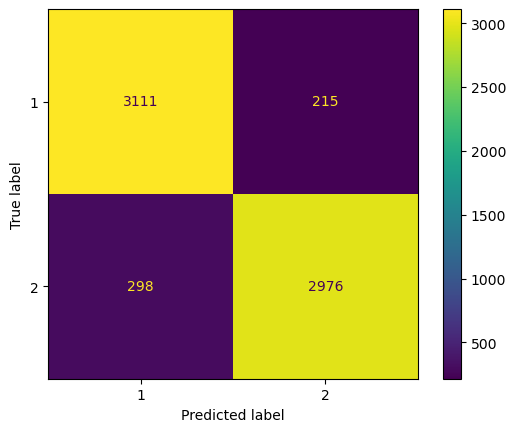

In [9]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=clf.classes_)
disp.plot()
plt.show()

# 3. Calibration of data

### Using method from the paper [1].

In [10]:
points_per_bin=50

# initialize recalibrator and set number of points per bins
hb = calibration.HB_toplabel(points_per_bin=points_per_bin)
hb.fit(preds_calib, y_calib)

# get histogram binning probabilities on test data
preds_test_hb = hb.predict_proba(preds_test)

### Using MAPIE `calibration.py`

In [11]:
mapie_reg = MapieCalibrator(estimator=clf, cv="prefit")
mapie_reg.fit(X_calib, y_calib)
mapie_prob_preds = mapie_reg.predict_proba(X_test)
mapie_preds = mapie_reg.predict(X_test)


In [12]:
# Verification that the same predictions are made.
np.testing.assert_array_equal(mapie_preds, clf.classes_[np.argmax(mapie_prob_preds, axis=1)])
np.testing.assert_array_equal(mapie_preds, arg_max_preds_test)

# 4. Evaluating the models using ECE and Reliability diagrams created in the paper.

Note that since we use different calibration methods, the results are slightly different, however, we still find similar results.

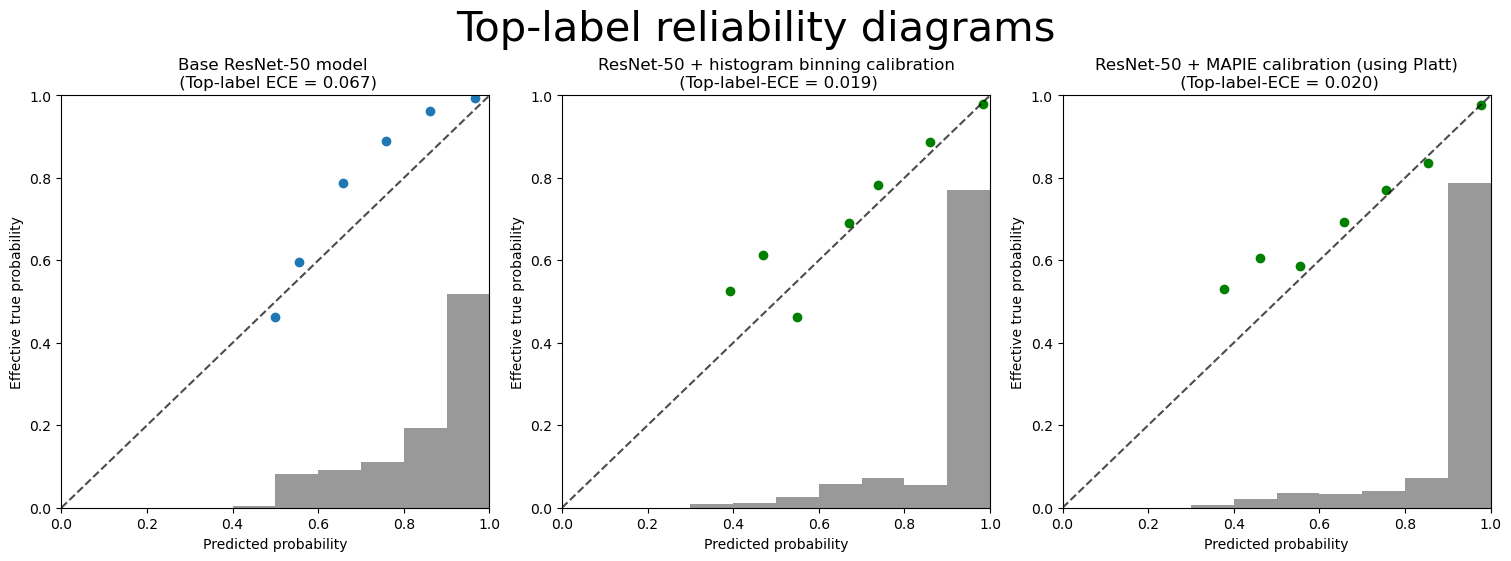

In [13]:
# make some plots
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5.5), constrained_layout=True)
fig.suptitle('Top-label reliability diagrams', fontsize=30)

assessment.toplabel_reliability_diagram(y_test, preds_test, ax=ax[0])
ax[0].set_title("Base ResNet-50 model \n (Top-label ECE = {:.3f})".format(top_label_ece(y_test, np.max(preds_test, axis=1), arg_max_preds_test)))

assessment.toplabel_reliability_diagram(y_test, preds_test_hb, arg_max_preds_test, ax=ax[1], color='g')
ax[1].set_title("ResNet-50 + histogram binning calibration\n (Top-label-ECE = {:.3f})".format(top_label_ece(y_test, preds_test_hb, arg_max_preds_test)));

assessment.toplabel_reliability_diagram(y_test, np.max(mapie_prob_preds, axis=1), arg_max_preds_test, ax=ax[2], color='g')
ax[2].set_title("ResNet-50 + MAPIE calibration (using Platt)\n (Top-label-ECE = {:.3f})".format(top_label_ece(y_test, np.max(mapie_prob_preds, axis=1), arg_max_preds_test)));

In [14]:
!rm -r -f df-posthoc-calibration